# Collaborative filtering
Fabian Mijsters 432601@student.saxion.nl

## Dataset analysis

Here all the necessary libraries get imported into the project. The dataset csv files are turned into pandas dataframes for easier handling

In [1]:
from IPython.core.display import HTML
from movie_display import movie_display
from IPython.display import display
from IPython.display import clear_output
from ipywidgets import Output
import seaborn as sns
import time
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import re
import numpy as np
import ipywidgets as widgets


movies_filename = 'dataset/movies.csv'
ratings_filename = 'dataset/ratings.csv'
links_filename = 'dataset/links.csv'
tags_filename = 'dataset/tags.csv'
imdbdata_filename = 'dataset/imdbdata.json'

movies_dataset = pd.read_csv(movies_filename)
ratings_dataset = pd.read_csv(ratings_filename)
links_dataset = pd.read_csv(links_filename)
tags_dataset = pd.read_csv(tags_filename)
imdb_dataset = pd.read_json(imdbdata_filename)




To give the user N recommendations the predifined dataset is turned into a dataframe with the user_id as index and the movie_id as column. This makes it easier to look up the ratings of a user or the ratings of a movie. The idea behind User-User recommendations is recommending N movies to a given user based on the ratings of movies that similar users have rated positively and the given user has not yet seen. 

In [2]:
dataframe_matrix_user_movie = pd.crosstab(index=ratings_dataset['userId'], columns=ratings_dataset['movieId'],values=ratings_dataset['rating'],aggfunc=np.mean,dropna=False)


# Distributions

In the data science field it is important to know how your data is build up, if there are any unique cases and as many features you can find about your data. Here a few graphs are shown to better understand the data

### How often is a movie rated

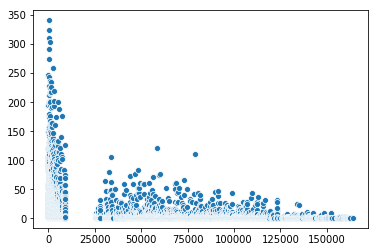

In [3]:
sns.scatterplot(data=dataframe_matrix_user_movie[dataframe_matrix_user_movie.columns].count())


### How often is a specific rating given

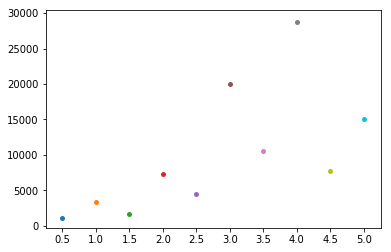

In [4]:
rating_dict = {0.5:0,1.0:0,1.5:0,2.0:0,2.5:0,3.0:0,3.5:0,4.0:0,4.5:0,5.0:0}
for index,item in dataframe_matrix_user_movie.apply(pd.value_counts).T.stack().iteritems():
    rating_dict[index[1]] += item
    
sns.swarmplot(data=pd.DataFrame.from_dict(rating_dict,orient='index').swapaxes('index','columns'))


### Average rating for the first 100 movies

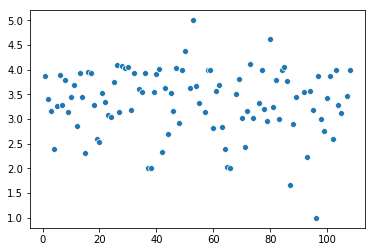

In [5]:
sns.scatterplot(data=dataframe_matrix_user_movie[dataframe_matrix_user_movie.columns[:100]].mean())

### Average rating of 20 users

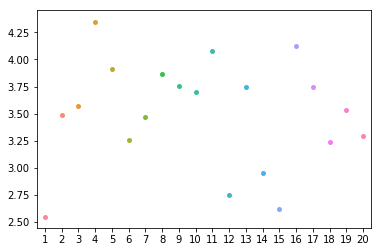

In [6]:
user_avg_rating = dict()
dataframe_matrix_user_movie.loc[1].mean()
for i in dataframe_matrix_user_movie.index[:20]:
    user_avg_rating[i] = dataframe_matrix_user_movie.loc[i].mean()

data_frame = pd.DataFrame.from_dict(user_avg_rating,orient='index').swapaxes('index','columns')
sns.swarmplot(data=data_frame)


# pd.DataFrame.from_dict(user_avg_rating,orient='index').swapaxes('index','columns')
# dataframe_matrix_user_movie.loc[:].mean()

### Average rating of all users

In [7]:
for i in dataframe_matrix_user_movie.index:
    user_avg_rating[i] = dataframe_matrix_user_movie.loc[i].mean()
    
data_frame = pd.DataFrame.from_dict(user_avg_rating,orient='index').swapaxes('index','columns')
data_frame.loc[0].mean()  

3.657586893206866

### Min max ratings

In [8]:
min(dataframe_matrix_user_movie[dataframe_matrix_user_movie.columns].count())
print('Movie with the least ratings',dataframe_matrix_user_movie[dataframe_matrix_user_movie.columns].count().idxmin())
print('Movie with the most ratings',dataframe_matrix_user_movie[dataframe_matrix_user_movie.columns].count().idxmax())
# dataframe_matrix_user_movie[dataframe_matrix_user_movie.columns].count()[40:60]

Movie with the least ratings 53
Movie with the most ratings 356


### Remove movies that have less than 10 ratings

This gets done because when a movie has less than 10 ratings its score can be skewed positively or negatively. The number 10 is based on trying to reduce the RMSE value. The number 10 ensured the lowest RMSE value.

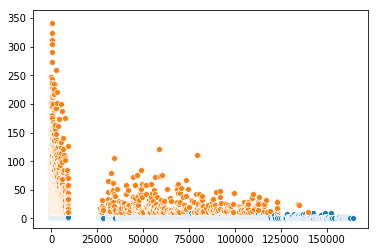

In [9]:
sns.scatterplot(data=dataframe_matrix_user_movie[dataframe_matrix_user_movie.columns].count())
boolean_indices = dataframe_matrix_user_movie[dataframe_matrix_user_movie.columns].count().apply(lambda x: x>10)

dataframe_matrix_user_movie = dataframe_matrix_user_movie[boolean_indices.index[boolean_indices]]

sns.scatterplot(data=dataframe_matrix_user_movie[dataframe_matrix_user_movie.columns].count())

### Remove users that have less than 10 ratings

This gets done because when a user has less than 10 ratings its score can be skewed positively or negatively

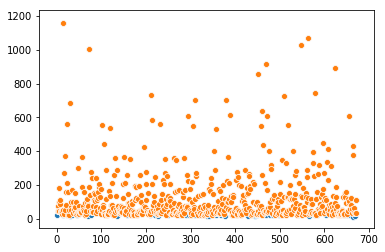

In [10]:
sns.scatterplot(data=dataframe_matrix_user_movie[dataframe_matrix_user_movie.columns].count(axis=1))
dataframe_matrix_user_movie = dataframe_matrix_user_movie[dataframe_matrix_user_movie.count(axis=1).apply(lambda x: x>20)]
sns.scatterplot(data=dataframe_matrix_user_movie[dataframe_matrix_user_movie.columns].count(axis=1))

## Proof of algorithms

To proof that the algorithms are correct we take the examples that are given in the slides and compare these to similarity values that are calculated using the implemented algorithms. It's clear that the algorithms work correctly since the values are the same

In [11]:
test_dataframe = pd.DataFrame(columns=['hp1','hp2','hp3','tw','sw1','sw2','sw3'])
test_dataframe.loc[0]=[4,np.nan,np.nan,5,1,np.nan,np.nan]
test_dataframe.loc[1]=[5,5,4,np.nan,np.nan,np.nan,np.nan]
test_dataframe.loc[2]=[np.nan,np.nan,np.nan,2,4,5,np.nan]
test_dataframe.loc[3]=[np.nan,3,np.nan,np.nan,np.nan,np.nan,3]

print("PROOF OF CONCEPT")

avg_per_user_poc = test_dataframe.mean(axis=1)
avg_per_item_poc = test_dataframe.mean(axis=0)

cosine_similarity_data_poc = cosine_similarity(test_dataframe.fillna(0),test_dataframe.fillna(0))
adjusted_cosine_similarity_data_poc = cosine_similarity(test_dataframe.sub(avg_per_item_poc,axis=1).fillna(0),test_dataframe.sub(avg_per_item_poc,axis=1).fillna(0))
pearson_similarity_data_poc = cosine_similarity(test_dataframe.sub(avg_per_user_poc,axis=0).fillna(0),test_dataframe.sub(avg_per_user_poc,axis=0).fillna(0))

user_user_cosine_df_poc = pd.DataFrame(columns=test_dataframe.index,index=test_dataframe.index,data=cosine_similarity_data_poc)
user_user_adjusted_df_poc = pd.DataFrame(columns=test_dataframe.index,index=test_dataframe.index,data=adjusted_cosine_similarity_data_poc)
user_user_pearson_df_poc = pd.DataFrame(columns=test_dataframe.index,index=test_dataframe.index,data=pearson_similarity_data_poc)

print("Correct awnsers are based on slide examples")

print('calculated cosine:',user_user_cosine_df_poc.loc[0][1], 'Correct awnser:',0.38)
print('calculated cosine:',user_user_cosine_df_poc.loc[0][2], 'Correct awnser:',0.32)
print('calculated pearson:',user_user_pearson_df_poc.loc[0][1], 'Correct awnser:',0.092)
print('calculated pearson:',user_user_pearson_df_poc.loc[0][2], 'Correct awnser:',-0.559)
print('calculated adjusted:',user_user_adjusted_df_poc.loc[0][1], 'Correct awnser:',-0.1025)
print('calculated adjusted:',user_user_adjusted_df_poc.loc[0][2], 'Correct awnser:',-0.9733)


PROOF OF CONCEPT
Correct awnsers are based on slide examples
calculated cosine: 0.3798685881987931 Correct awnser: 0.38
calculated cosine: 0.3220305943597653 Correct awnser: 0.32
calculated pearson: 0.09245003270420474 Correct awnser: 0.092
calculated pearson: -0.5590852462516898 Correct awnser: -0.559
calculated adjusted: -0.1025978352085154 Correct awnser: -0.1025
calculated adjusted: -0.9733285267845752 Correct awnser: -0.9733


## User-user recommendations

### Creating and filling a dataframe with the cosine similarity, pearson similarity, adjusted cosine similarity

Comparing a lot of items to each other is usually very slow and slows down exponentially based on the amount of items. To increase the speed of the recommendation system 3 predefined dataframes are created with all the calculated similarities. This is done very fast by comparing matrices to each other instead of single rows.

In [12]:
avg_per_user = dataframe_matrix_user_movie.mean(axis=1)
avg_per_item = dataframe_matrix_user_movie.mean(axis=0)

In [13]:
start_time_item_ms = time.time()*1000.0

cosine_similarity_data = cosine_similarity(dataframe_matrix_user_movie.fillna(0),dataframe_matrix_user_movie.fillna(0))
adjusted_cosine_similarity_data = cosine_similarity(dataframe_matrix_user_movie.sub(avg_per_item,axis=1).fillna(0),dataframe_matrix_user_movie.sub(avg_per_item,axis=1).fillna(0))
pearson_similarity_data = cosine_similarity(dataframe_matrix_user_movie.sub(avg_per_user,axis=0).fillna(0),dataframe_matrix_user_movie.sub(avg_per_user,axis=0).fillna(0))

user_user_cosine_df = pd.DataFrame(columns=dataframe_matrix_user_movie.index,index=dataframe_matrix_user_movie.index,data=cosine_similarity_data)
user_user_adjusted_df = pd.DataFrame(columns=dataframe_matrix_user_movie.index,index=dataframe_matrix_user_movie.index,data=adjusted_cosine_similarity_data)
user_user_pearson_df = pd.DataFrame(columns=dataframe_matrix_user_movie.index,index=dataframe_matrix_user_movie.index,data=pearson_similarity_data)


end_time = time.time()*1000.0
print("Time:",round((end_time-start_time_item_ms)/1000),"s")

Time: 0 s


## Item-item recommendations

Next to the user-user recommendations there is also the possibility to get recommendations based on the similarities of certain movies. This is done by comparing movies to each other and using this similarity value to predict the rating for a user. Out of this list with predictions the N highest values are chosen and recommended to the user.

In [14]:
dataframe_matrix_movie_user = dataframe_matrix_user_movie.swapaxes('index','columns')
avg_per_user = dataframe_matrix_movie_user.mean(axis=1)
avg_per_item = dataframe_matrix_movie_user.mean(axis=0)

### Creating and filling a dataframe with the cosine similarity, pearson similarity, adjusted cosine similarity

The same as above gets done for the swapped dataframe and now comparing items instead of users.

In [15]:
start_time_item_ms = time.time()*1000.0

cosine_similarity_data = cosine_similarity(dataframe_matrix_movie_user.fillna(0),dataframe_matrix_movie_user.fillna(0))
adjusted_cosine_similarity_data = cosine_similarity(dataframe_matrix_movie_user.sub(avg_per_item,axis=1).fillna(0),dataframe_matrix_movie_user.sub(avg_per_item,axis=1).fillna(0))
pearson_similarity_data = cosine_similarity(dataframe_matrix_movie_user.sub(avg_per_user,axis=0).fillna(0),dataframe_matrix_movie_user.sub(avg_per_user,axis=0).fillna(0))

item_item_cosine_df = pd.DataFrame(columns=dataframe_matrix_user_movie.columns,index=dataframe_matrix_user_movie.columns,data=cosine_similarity_data)
item_item_adjusted_df = pd.DataFrame(columns=dataframe_matrix_user_movie.columns,index=dataframe_matrix_user_movie.columns,data=adjusted_cosine_similarity_data)
item_item_pearson_df = pd.DataFrame(columns=dataframe_matrix_user_movie.columns,index=dataframe_matrix_user_movie.columns,data=pearson_similarity_data)


end_time = time.time()*1000.0
print("Time:",round((end_time-start_time_item_ms)/1000),"s")

Time: 0 s


These functions are used to translate the measure choices of the user to a single list to make it usable in a function. 

In [16]:
def get_similarity_for_user(similarity_measure,user_id):
    if similarity_measure == 'Cosine Similarity':
        return user_user_cosine_df.loc[user_id].values
    elif similarity_measure == 'Pearson Similarity':
        return user_user_pearson_df.loc[user_id].values
    elif similarity_measure == 'Adjusted Cosine Similarity':
        return user_user_adjusted_df.loc[user_id].values
    else:
        return None

In [17]:
def get_similarity_for_item(similarity_measure,user_id):
    if similarity_measure == 'Cosine Similarity':
        return item_item_cosine_df
    elif similarity_measure == 'Pearson Similarity':
        return item_item_pearson_df
    elif similarity_measure == 'Adjusted Cosine Similarity':
        return item_item_adjusted_df
    else:
        return None

## Predicting ratings based on similarity for user-user

To predict the ratings a user will give to a certain movie using the user-user method there are a few steps that need to be followed.  

First the 10 highest similar users are taken from the similarity list. This similarity list can be based on cosine similarity, pearson similarity or adjusted cosine similarity. The highest value will always be the user itself since they are the same so this value gets removed from the array. 

Secondly a dictionary is created with the 10 most similar users as keys and their similarity values as values. 

The third step is calculating all the ratings the user would give to the movies that the most similar users rated. While doing this checking occurs to make sure the user has not seen a recommendation. 

Finally a dictionary is created with the movieIds as keys and the predicted rating as value. This dictionary is sorted and the top N highest ratings are extracted and returned. 

In [27]:
import operator
def get_user_recommendations(similarity_list,n_similarities,user_id,matrix,for_test=False):
    current_user = matrix.loc[user_id]    
    similarity_highest_list = np.asarray(similarity_list).argsort()[:-12:-1]
    similarity_highest_list = np.delete(similarity_highest_list,0)
    
    user_list =list()
    user_sim_dict = dict()
    for index,sim_score in enumerate(similarity_list[similarity_highest_list]):
        user_sim_dict[matrix.index.values[similarity_highest_list[index]]] = sim_score
    result_dict = dict()
    for sim_user_id,user_sim_score in user_sim_dict.items():
        similar_user_list = matrix.loc[sim_user_id]
        for movie_id,movie_rating in similar_user_list.items():

            if not np.isnan(movie_rating) and np.isnan(current_user[movie_id]):

                new_movie_rating = (movie_rating * user_sim_score)  + avg_per_user.loc[movie_id]
                if for_test:
                    current_user[movie_id] = new_movie_rating
                if movie_id in result_dict.keys() and result_dict[movie_id] < new_movie_rating:
                    result_dict[movie_id] = new_movie_rating
                elif movie_id not in result_dict.keys():
                    result_dict[movie_id] = new_movie_rating

    if for_test:
        return current_user
    sorted_result_dict = sorted(result_dict.items(), key=operator.itemgetter(1),reverse=True)[:n_similarities]
    return sorted_result_dict

## Predicting ratings based on similarity for item-item

To predict ratings based on the item-item method the ratings that are atleast a certain threshold (in this case 3.5) are collected and these are scaled based on the most similar movies. These predicted ratings are added into the ratings of the user and returned


In [19]:
def get_predicted_ratings(user_id,similarity_list,user_movie_matrix,similar_users=4,for_test=False):    
    user_ratings = user_movie_matrix.loc[user_id].copy()
    ratings_higher_than_threshold = user_ratings[user_ratings.apply(lambda x: x>=3.5)]
    if for_test:
        ratings_higher_than_threshold = user_ratings[user_ratings.apply(lambda x: not np.isnan(x))]
    
    for i,rating in enumerate(user_ratings[user_ratings.apply(lambda rating: np.isnan(rating))]):
    
        similar_movies_scores =  np.asarray(similarity_list.iloc[i].loc[ratings_higher_than_threshold.index])
        similar_indices_higher = np.where(similar_movies_scores > 0)[0]
        highest_similar_movies_scores_indices = similar_movies_scores[similar_indices_higher].argsort()[:-(similar_users+2):-1]
        rated_indices = ratings_higher_than_threshold.iloc[highest_similar_movies_scores_indices].index
        scaled_ratings = list()
        sum_of_scaled_ratings = np.dot(similar_movies_scores[similar_indices_higher][highest_similar_movies_scores_indices],user_ratings[rated_indices].values)
        calculated_rating = sum_of_scaled_ratings/np.sum(similar_movies_scores[similar_indices_higher][highest_similar_movies_scores_indices])  
        user_ratings.iloc[i] = calculated_rating
            
    return user_ratings
        


Here the get_predicted_ratings function is called to get the predictions for each movie based on a number of similar users. These ratings get sorted using the same method as before and then the top n highest ratings are returned

In [20]:
def get_item_recommendations(similarity_list,n_similarities,user_id,matrix):        
    user_ratings = get_predicted_ratings(user_id,similarity_list,matrix,similar_users=4)
    old_user_ratings = matrix.loc[user_id].copy()
    recommendations = dict()
    for index in range(len(user_ratings)):
        if np.isnan(old_user_ratings.iloc[index]) and not np.isnan(user_ratings.iloc[index]):
            recommendations[matrix.columns[index]] = user_ratings.iloc[index]
            
    sorted_result_dict = sorted(recommendations.items(), key=operator.itemgetter(1),reverse=True)[:n_similarities]
    return sorted_result_dict
    

## IMDB 
This function translates a movieId from the ratings.csv file to an imdbId based on the links.csv file. These imdbIds are used to show the user the recommendations using the movie_display library

In [21]:
def indices_to_dataframe_indices(sorted_result_dict):
    recommendations_list = list()
    for key,value in sorted_result_dict:
        imdbid = links_dataset[links_dataset['movieId'] == key].imdbId.values[0]
        index_in_dataset = np.where(np.asarray([imdb_dataset['imdbId'] == imdbid]) == True)
        if len(index_in_dataset[1]) == 0:
            continue
        index_in_dataset = index_in_dataset[1][0]
        recommendations_list.append(imdb_dataset.loc[index_in_dataset])
    
    return recommendations_list

# Dashboard

The dashboard can be used to get recommendations based on the 3 similarity lists and the 2 different methods (user-user,item-item)  
The dashboard is build using ipywidgets. The dashboard takes the user input and calls the correct functions that the user wants to use. The recommendations then get shown to the user using the movie_display dataset. If the user wants to try another way of getting recommendations the user can use the clear button to reset the dashboard or change the choices and press the find similarity button. 

In [22]:
import ipywidgets as ipy
dropdown_options_item_user = widgets.Dropdown(options = ['user-user','item-item'])
dropdown_options_similarity_metric = widgets.Dropdown(options = ['Cosine Similarity','Pearson Similarity','Adjusted Cosine Similarity'])
dropdown_user = widgets.Dropdown(options = dataframe_matrix_user_movie.index)

def show_dashboard():
    out = Output()
    
    def btn_eventhandler(obj):
        with out:
            clear_output()
        n_similarities = int(input_widget2.value)
        similarity_list = None
        if dropdown_options_item_user.value == "item-item":
            similarity_list = get_similarity_for_item(dropdown_options_similarity_metric.value,dropdown_user.value)
            sorted_result_dict = get_item_recommendations(similarity_list,n_similarities,dropdown_user.value,dataframe_matrix_user_movie)
            similar_movies = indices_to_dataframe_indices(sorted_result_dict)
            
        elif dropdown_options_item_user.value == "user-user":
            similarity_list = get_similarity_for_user(dropdown_options_similarity_metric.value,dropdown_user.value)
            sorted_result_dict = get_user_recommendations(similarity_list,n_similarities,dropdown_user.value,dataframe_matrix_user_movie)
            similar_movies = indices_to_dataframe_indices(sorted_result_dict)

        with out:
            print("These are your recommendations")
            display(HTML(movie_display.show(similar_movies)))

    def btn_eventhandler3(obj):
        try: 
            with out: 
                clear_output()
        except Exception as e:
            print(e)

    btn = widgets.Button(description='Get recommendations')    
    btn2 = widgets.Button(description='Clear')    

    btn.on_click(btn_eventhandler)
    btn2.on_click(btn_eventhandler3)

    input_widget2 = widgets.FloatText(
        value=3,
        description='N similar:',
        disabled=False)
    
    print("Select user id")
    
    display(dropdown_options_item_user)
    display(dropdown_user)
    display(dropdown_options_similarity_metric)
    display(input_widget2)
    display(btn)
    display(btn2)
    display(out)



In [23]:
show_dashboard()

Select user id


Dropdown(options=('user-user', 'item-item'), value='user-user')

Dropdown(options=(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, …

Dropdown(options=('Cosine Similarity', 'Pearson Similarity', 'Adjusted Cosine Similarity'), value='Cosine Simi…

FloatText(value=3.0, description='N similar:')

Button(description='Get recommendations', style=ButtonStyle())

Button(description='Clear', style=ButtonStyle())

Output()

# validation

To ensure that the given recommendations are usefull for the user some validation techniques can be used. Hit Rate A-B testing and RMSE are popular ones. 

### Hit Rate

To calculate the hitrate of a recommendation the highest value of each array gets removed. Then the recommendations for this user are requested. These recommendations are checked for the deleted movie. If its in there add 1 to the hits else 1 to the misses. Finally devide the hits by the total movies. 

In [24]:
def get_hit_rate(n_sims,measure,dataframe,item_item):
    with output:
        clear_output(wait=True)
        print(measure, 'for',n_sims,'recommendations')
    removed_rating = dict()
    dataframe_backup = dataframe_matrix_user_movie.copy()

    for index,row in dataframe_backup.iterrows():
        removed_rating[index] = row.idxmax()
        dataframe_backup.loc[index].loc[row.idxmax()] = np.nan


    hit = 0
    miss = 0
    for index,(user_id,deleted_movie) in enumerate(removed_rating.items()):
        f.value = round((index+1)/len(removed_rating.keys()) *100)
        f.description = str(round((index+1)/len(removed_rating.keys()) *100)) + "%"
        movie_names = list()
        if item_item:
            for movie in get_item_recommendations(dataframe,n_sims,user_id,dataframe_backup):
                movie_names.append(movie[0])
        else:
            for movie in get_user_recommendations(dataframe.loc[user_id].values,n_sims,user_id,dataframe_backup):
                movie_names.append(movie[0])
        if deleted_movie in movie_names:
            hit +=1
        else:
            miss +=1
    return hit,miss

Functions that fancy print the hitrate for both the methods and all three of the similarities. Also shows progressbar

In [344]:
f= widgets.IntProgress(description='0%',min=0,max=100)
output = Output()
display(output)
display(f)


for n_sims in [10,25,50]:
    for measure,dataframe in {"Cosine Similarity":user_user_cosine_df,"Pearson Similarity":user_user_pearson_df,"Adjusted Cosine Similarity":user_user_adjusted_df}.items():
        hit,miss = get_hit_rate(n_sims,measure,dataframe,False)
        print(measure, 'for',n_sims,'recommendations')
        print("hits:",hit,"misses:",miss)
        print("hit_rate:",round(hit/(hit+miss) * 100,2),'%')
        print("")

Output()

IntProgress(value=0, description='0%')

Cosine Similarity for 10 recommendations
hits: 153 misses: 469
hit_rate: 24.6 %

Pearson Similarity for 10 recommendations
hits: 164 misses: 458
hit_rate: 26.37 %

Adjusted Cosine Similarity for 10 recommendations
hits: 120 misses: 502
hit_rate: 19.29 %

Cosine Similarity for 25 recommendations
hits: 257 misses: 365
hit_rate: 41.32 %

Pearson Similarity for 25 recommendations
hits: 237 misses: 385
hit_rate: 38.1 %

Adjusted Cosine Similarity for 25 recommendations
hits: 202 misses: 420
hit_rate: 32.48 %

Cosine Similarity for 50 recommendations
hits: 327 misses: 295
hit_rate: 52.57 %

Pearson Similarity for 50 recommendations
hits: 311 misses: 311
hit_rate: 50.0 %

Adjusted Cosine Similarity for 50 recommendations
hits: 278 misses: 344
hit_rate: 44.69 %



In [345]:
f= widgets.IntProgress(description='0%',min=0,max=100)
output = Output()
display(output)
display(f)


for n_sims in [10,25,50]:
    for measure,sim_dataframe in {"Cosine Similarity":item_item_cosine_df,"Pearson Similarity":item_item_pearson_df,"Adjusted Cosine Similarity":item_item_adjusted_df}.items():
        hit,miss = get_hit_rate(n_sims,measure,sim_dataframe,True)
        print(measure, 'for',n_sims,'recommendations')
        print("hits:",hit,"misses:",miss)
        print("hit_rate:",round(hit/(hit+miss)* 100,2),'%')
        print("")

Output()

IntProgress(value=0, description='0%')

C:\Users\fmijs\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


Cosine Similarity for 10 recommendations
hits: 63 misses: 559
hit_rate: 10.13 %

Pearson Similarity for 10 recommendations
hits: 29 misses: 593
hit_rate: 4.66 %

Adjusted Cosine Similarity for 10 recommendations
hits: 34 misses: 588
hit_rate: 5.47 %

Cosine Similarity for 25 recommendations
hits: 100 misses: 522
hit_rate: 16.08 %

Pearson Similarity for 25 recommendations
hits: 61 misses: 561
hit_rate: 9.81 %

Adjusted Cosine Similarity for 25 recommendations
hits: 72 misses: 550
hit_rate: 11.58 %

Cosine Similarity for 50 recommendations
hits: 137 misses: 485
hit_rate: 22.03 %

Pearson Similarity for 50 recommendations
hits: 90 misses: 532
hit_rate: 14.47 %

Adjusted Cosine Similarity for 50 recommendations
hits: 108 misses: 514
hit_rate: 17.36 %



### RMSE

The RMSE validation technique takes a portion of the users and a portion of movies of these users using the sample method of a dataframe. The missing ratings are then calculated using the item-item and user-user techinques and compared to the removed ratings. The root mean squared error is then calculated and shown

RMSE for user-user

In [28]:


f= widgets.IntProgress(description='0%',min=0,max=100)
display(f)


for measure,dataframe in {"Cosine Similarity":user_user_cosine_df,"Pearson Similarity":user_user_pearson_df,"Adjusted Cosine Similarity":user_user_adjusted_df}.items():
    test_set = dataframe_matrix_user_movie.sample(n=100,axis=(1),random_state=2).sample(n=30,axis=0,random_state=2)
    train_set = dataframe_matrix_user_movie.copy()

    for index,row in test_set.iterrows():
        train_set.loc[index].loc[row.index] = np.nan
    rmse_list= list()
    for index,(user_id,ratings) in enumerate(test_set.iterrows()):
        f.value = round((index+1)/30 *100)
        f.description = str(round((index+1)/30 *100))+ '%'
        current_user = train_set.loc[user_id]    
        predicted_ratings = get_user_recommendations(dataframe.loc[user_id],10,user_id,train_set,for_test=True)
        rmse = np.sqrt(np.mean((predicted_ratings-test_set.loc[user_id])**2))
        if not np.isnan(rmse):
            rmse_list.append(rmse)

    
    print(measure,'RMSE:',round(sum(rmse_list) / len(rmse_list),3),'%')


IntProgress(value=0, description='0%')

C:\Users\fmijs\Anaconda3\lib\site-packages\pandas\core\series.py:841: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


Cosine Similarity RMSE: 0.883 %
Pearson Similarity RMSE: 0.772 %
Adjusted Cosine Similarity RMSE: 0.782 %


RMSE for item-item

In [340]:

f= widgets.IntProgress(description='0%',min=0,max=100)
display(f)

for measure,sim_dataframe in {"Cosine Similarity":item_item_cosine_df,"Pearson Similarity":item_item_pearson_df,"Adjusted Cosine Similarity":item_item_adjusted_df}.items():
    test_set = dataframe_matrix_user_movie.sample(n=100,axis=(1),random_state=1).sample(n=30,axis=0,random_state=1)
    train_set = dataframe_matrix_user_movie.copy()

    for index,row in test_set.iterrows():
        train_set.loc[index].loc[row.index] = np.nan

    rmse_list= list()
    for index,(user_id,ratings) in enumerate(test_set.iterrows()):
        f.value = round((index+1)/30 *100)
        f.description = str(round((index+1)/30 *100))+ '%'
        predicted_ratings = get_predicted_ratings(user_id,sim_dataframe,train_set,similar_users=10,for_test=True)
        rmse = np.sqrt(np.mean((predicted_ratings-test_set.loc[user_id])**2))
        if not np.isnan(rmse):
            rmse_list.append(rmse)

    
    print(measure,'RMSE:',round(sum(rmse_list) / len(rmse_list),3),'%')

IntProgress(value=0, description='0%')

Cosine Similarity RMSE: 0.817 %
Pearson Similarity RMSE: 0.858 %


C:\Users\fmijs\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


Adjusted Cosine Similarity RMSE: 0.878 %


In [336]:
import ipywidgets as ipy
dropdown_options_item_user = widgets.Dropdown(options = ['user-user','item-item'])
dropdown_options_similarity_metric = widgets.Dropdown(options = ['Cosine Similarity','Pearson Similarity','Adjusted Cosine Similarity'])
dropdown_user = widgets.Dropdown(options = dataframe_matrix_user_movie.index)

def show_dashboard_for_predicted_ratings():
    out = Output()
    
    def btn_eventhandler(obj):
        with out:
            clear_output()
        n_similarities = int(input_widget2.value)
        similarity_list = None
        if dropdown_options_item_user.value == "item-item":
            similarity_list = get_similarity_for_item(dropdown_options_similarity_metric.value,dropdown_user.value)
            sorted_result_dict = get_item_recommendations(similarity_list,n_similarities,dropdown_user.value,dataframe_matrix_user_movie)
            similar_movies = indices_to_dataframe_indices(sorted_result_dict)
            
        elif dropdown_options_item_user.value == "user-user":
            similarity_list = get_similarity_for_user(dropdown_options_similarity_metric.value,dropdown_user.value)
            sorted_result_dict = get_user_recommendations(similarity_list,n_similarities,dropdown_user.value,dataframe_matrix_user_movie)
            similar_movies = indices_to_dataframe_indices(sorted_result_dict)
        
       
            
        with out:
            for index, movie in enumerate(similar_movies):
                print(movie.Title,5 if sorted_result_dict[index][1] > 5 else  sorted_result_dict[index][1])
            print("These are your recommendations")
            display(HTML(movie_display.show(similar_movies)))

    def btn_eventhandler3(obj):
        try: 
            with out: 
                clear_output()
        except Exception as e:
            print(e)

    btn = widgets.Button(description='Get recommendations')    
    btn2 = widgets.Button(description='Clear')    

    btn.on_click(btn_eventhandler)
    btn2.on_click(btn_eventhandler3)

    input_widget2 = widgets.FloatText(
        value=3,
        description='N similar:',
        disabled=False)
    
    print("Select user id")
    
    display(dropdown_options_item_user)
    display(dropdown_user)
    display(dropdown_options_similarity_metric)
    display(input_widget2)
    display(btn)
    display(btn2)
    display(out)



In [337]:
show_dashboard_for_predicted_ratings()

Select user id


Dropdown(options=('user-user', 'item-item'), value='user-user')

Dropdown(options=(2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, …

Dropdown(options=('Cosine Similarity', 'Pearson Similarity', 'Adjusted Cosine Similarity'), value='Cosine Simi…

FloatText(value=3.0, description='N similar:')

Button(description='Get recommendations', style=ButtonStyle())

Button(description='Clear', style=ButtonStyle())

Output()